# **Step 1:** Training a <nobr>Micro$\mathbb{S}$plit</nobr> Model

# Introduction - what does this notebook do?

<div class="alert alert-block alert-info">
<b>Note:</b> Despite network training arguably being the most important step, the execution of this notebook is optional. If you do not run this notebook, in Step 2 (prediction) we offer you to use pretrained model checkpoints. Like in any respected cooking show: "we have already prepared someting before the show"... 😉
</div>

Below, we will train a <nobr>Micro$\mathbb{S}$plit</nobr> network for removing unwanted imaging artifacts from our HT_H23B dataset. 

More specifically, we imaged the post-mitotic neuronal marker CTIP2 in sliced hPSC-derived forebrain
organoids using a secondary antibody conjugated to a 555 dye. The resulting image data not only had
CTIP2+ nuclear staining (wanted signal), but also puncta that accumulated because of non-specific signal
(i.e. undesired artifacts).
Ideally, we could use MicroSplit to unmix the labeled nuclei (desired image content) and the undesired
puncta (i.e. imaging artifacts). However, for this we would need training targets that contain only nuclei
and others that contain only puncta, a requirement that this experimental setup does not
permit. That's why we manually selected image regions that show
only the artifacts (puncta) or only the desired structures (the signal, in this example, nuclei). The selected
image regions are then combined and used to train a MicroSplit
network. Since crops without puncta or crops that show only puncta are of limited size with respect to full
microscopy images (the smallest crops we collected were 100 → 100 pixels), lateral contextualization could not be used and was therefore disabled during training. In total, we have manually
cropped 82 content regions and 48 puncta regions from the data. This took an analyst about eight hours of focused work.

Here, we assume that images of each single structure exist, but we no longer assume that all structures have
been imaged in each sample. As before, here we also generate superimposed inputs by summing images showing different fluorescent structures. However, unlike before, summed-up input images no longer originate
from the same sample, and any spatial correlations that might exist between these cellular structures
are lost

This dataset contains 2 labeled structures:
1. Puncta
2. Foreground


## Background: what is <nobr>Micro$\mathbb{S}$plit</nobr> training all about?
Training is done in a supervised way. For every input patch, we have the two corresponding target patches using which we train our MicroSplit. 
Besides the primary input patch, we also feed LC inputs to MicroSplit. We introduced LC inputs in [μSplit: efficient image decomposition for microscopy data](https://openaccess.thecvf.com/content/ICCV2023/papers/Ashesh_uSplit_Image_Decomposition_for_Fluorescence_Microscopy_ICCV_2023_paper.pdf), which enabled the network to understand the global spatial context around the input patch.

To enable unsupervised denoising, we integrated the KL loss formulation and Noise models from our previous work [denoiSplit: a method for joint microscopy image splitting and unsupervised denoising](https://eccv.ecva.net/virtual/2024/poster/2538). 

The loss function for MicroSplit is a weighted average of denoiSplit loss and μSplit loss. For both denoiSplit and μSplit, their loss expression have two terms: KL divergence loss and likelihood loss. For more details, please refer to the respective papers.

# Let's do it, let's train a <nobr>Micro$\mathbb{S}$plit</nobr> Model!

**You are new to Jupyter notebooks?** Don't worry, if you take the time to read all our explanations, we will guide you through them and you will understand a lot. Still, you will likely end up less frustrated, if you do not even start with the ambition to interpret the purpose of every line of code.
Let's start with a nice example, the imports to enable the remainder of this notebook. Ignore it (unless you know what you are doing) and just click **⇧*Shift* + ⏎*Enter*** to execute this (and all other) code cells. 

In [1]:
# importing all the things we need further down

import pooch
import matplotlib.pyplot as plt
from pytorch_lightning import Trainer
from torch.utils.data import DataLoader
from careamics.lightning import VAEModule

from microsplit_reproducibility.configs.factory import (
    create_algorithm_config,
    get_likelihood_config,
    get_loss_config,
    get_model_config,
    get_optimizer_config,
    get_training_config,
    get_lr_scheduler_config,
)
from microsplit_reproducibility.utils.callbacks import get_callbacks
from microsplit_reproducibility.utils.io import load_checkpoint, load_checkpoint_path
from microsplit_reproducibility.datasets import create_train_val_datasets
from microsplit_reproducibility.utils.utils import (
    plot_training_metrics,
    plot_training_outputs,
)

# Dataset specific imports...
from microsplit_reproducibility.configs.parameters.HT_H23B import get_microsplit_parameters
from microsplit_reproducibility.configs.data.HT_H23B import get_data_configs
from microsplit_reproducibility.datasets.HT_H23B import get_train_val_data

# **Step 1.1:** Data Preparation

### Download the data
Depending on your internet connection, this will take a while...

Note that appropriate noise models will only be downloaded if they were not created by executing the notebook `00_noisemodels.ipynb`.

In [2]:
DATA = pooch.create(
    path=f"./data/",
    base_url=f"https://download.fht.org/jug/msplit/ht_h23b/data/",
    registry={f"ht_h23b.zip": None},
)

NOISE_MODELS = pooch.create(
    path=f"./noise_models/",
    base_url=f"https://download.fht.org/jug/msplit/ht_h23b/noise_models/",
    registry={
        f"ht_h23b_nm_raw_data.npz": None,
    },
)

Note that the following notebook will download all you need. In case you see no messages announcing any downloads, you already have this data in the notebook folder.

In [3]:
for fname in NOISE_MODELS.registry:
    NOISE_MODELS.fetch(fname, progressbar=True)
print('---------')
for fname in DATA.registry:
    DATA.fetch(fname, processor=pooch.Unzip(), progressbar=True)

---------


### Next, we load the image data to be processed

Note that depending on the amount of GPU memory you have available, you might want to adjust the batch size. The default is 64, but you can reduce it to 32 if you run out of memory by changing the <i> batch_size </i> parameter in <i> get_microsplit_parameters </i> below.


***Note:*** if you want to use the noise model you trained in the previous notebook, change the `nm_fname` in the cell below to `user_trained_noise_model.npz`

In [5]:
nm_fname = "ht_h23b_nm_raw_data.npz"
# setting up train, validation, and test data configs
train_data_config, val_data_config, test_data_config = get_data_configs()
# setting up MicroSplit parametrization
experiment_params = get_microsplit_parameters(nm_path=NOISE_MODELS.path /nm_fname, batch_size=64
)

# start the download of required files
train_dset, val_dset, _, data_stats = create_train_val_datasets(
    datapath=DATA.path / f"ht_h23b.zip.unzip/",
    train_config=train_data_config,
    val_config=val_data_config,
    test_config=val_data_config,
    load_data_func=get_train_val_data,
)

Train: 38 Val: 5 Test: 5
Train: 61 Val: 17 Test: 4
Padding is not used with this alignement style
Train: 38 Val: 5 Test: 5
Train: 61 Val: 17 Test: 4
Padding is not used with this alignement style
Train: 38 Val: 5 Test: 5
Train: 61 Val: 17 Test: 4
Padding is not used with this alignement style


***Optional:*** inspect data configurations and <nobr>Micro$\mathbb{S}$plit</nobr> config

In [6]:
do_show_configs = True

if do_show_configs:
    print('FYI: train_data_config')
    print('----------------------')
    for cfg in train_data_config:
        print(cfg)

    print('\nFYI: experiment_params')
    print('----------------------')
    print(experiment_params)
else:
    print('You opted out of having all params printed... swiftly moving on... ;)')

FYI: train_data_config
----------------------
('data_type', <DataType.HTH23BData: 13>)
('depth3D', 1)
('datasplit_type', <DataSplitType.Train: 1>)
('num_channels', 2)
('ch1_fname', None)
('ch2_fname', None)
('ch_input_fname', None)
('input_is_sum', True)
('input_idx', None)
('target_idx_list', None)
('start_alpha', None)
('end_alpha', None)
('image_size', (64, 64))
('grid_size', 32)
('empty_patch_replacement_enabled', False)
('empty_patch_replacement_channel_idx', None)
('empty_patch_replacement_probab', None)
('empty_patch_max_val_threshold', None)
('uncorrelated_channels', True)
('uncorrelated_channel_probab', 1.0)
('poisson_noise_factor', -1.0)
('synthetic_gaussian_scale', 6675.0)
('input_has_dependant_noise', True)
('enable_gaussian_noise', False)
('allow_generation', False)
('training_validtarget_fraction', None)
('deterministic_grid', None)
('enable_rotation_aug', False)
('max_val', None)
('overlapping_padding_kwargs', {'mode': 'reflect'})
('print_vars', False)
('normalized_input

### Wanna trade speed for model quality? (1/2)
<div class="alert alert-block alert-info">
<b>Note:</b> If you just want to get an idea of the process of training <nobr>Micro$\mathbb{S}$plit</nobr> and you do not intend to get best-possible results, feel invited to crop down on the training data to be used further down. <i><b>Do not do this</b> if you intend to train a competitive model!!!</i>
</div>

### Final step: create Dataloaders for network training

In [7]:
train_dloader = DataLoader(
    train_dset,
    batch_size=experiment_params["batch_size"],
    num_workers=experiment_params["num_workers"],
    shuffle=True,
)
val_dloader = DataLoader(
    val_dset,
    batch_size=experiment_params["batch_size"],
    num_workers=experiment_params["num_workers"],
    shuffle=False,
)

# **Step 1.2:** Prepare <nobr>Micro$\mathbb{S}$plit</nobr> Training
Next, we create all the configs for the upcoming network training run. These lines are not very intuitive and if you don't intend to dive really deep into CAREamics and the internals of <nobr>Micro$\mathbb{S}$plit</nobr>, you might just execute these cells and move on.

In [8]:
# making our data_stas known to the experiment we prepare
experiment_params["data_stats"] = data_stats

# setting up training losses and model config (using default parameters)
loss_config = get_loss_config(**experiment_params)
model_config = get_model_config(**experiment_params)
gaussian_lik_config, noise_model_config, nm_lik_config = get_likelihood_config(
    **experiment_params
)
training_config = get_training_config(**experiment_params)

# setting up learning rate scheduler and optimizer (using default parameters)
lr_scheduler_config = get_lr_scheduler_config(**experiment_params)
optimizer_config = get_optimizer_config(**experiment_params)

# finally, assemble the full set of experiment configurations...
experiment_config = create_algorithm_config(
    algorithm=experiment_params["algorithm"],
    loss_config=loss_config,
    model_config=model_config,
    gaussian_lik_config=gaussian_lik_config,
    nm_config=noise_model_config,
    nm_lik_config=nm_lik_config,
    lr_scheduler_config=lr_scheduler_config,
    optimizer_config=optimizer_config,
)

/home/igor.zubarev/projects/careamics/src/careamics/utils/serializers.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(lst)


### Wanna trade speed for model quality? (2/2)
<div class="alert alert-block alert-info">
<b>Note:</b> Similar to above, if you simply want to go over this notebook quickly and you don't care about training a competitive model, set <i>`reduce_training_epochs=True`</i> in the cell below. 

Note that if <i> reduce_training_epochs </i> is set to <i>False </i>, the default number of epochs is 400. However, early stopping will be invoked when the loss is no longer decreasing, so the actual number of epochs trained will most likely be less than 400.
</div>

In [9]:
reduce_training_epochs = True

# if True, train for only 10 epochs (quick'n'dirty testing mode)
if reduce_training_epochs:
    training_config.num_epochs = 10

print(f'Will train for {training_config.num_epochs} epochs!')

Will train for 10 epochs!


## Initialize the <nobr>Micro$\mathbb{S}$plit</nobr> model to be trained..

In [10]:
model = VAEModule(algorithm_config=experiment_config)

[GaussianMixtureNoiseModel] min_sigma: 0.125
[GaussianMixtureNoiseModel] min_sigma: 0.125
[MultiChannelNoiseModel] Nmodels count:2


### *Load checkpoint (optional and for you to implement)*

<div class="alert alert-block alert-success">
<b>Note:</b> If you would like to continue a previous training run or finetune a compatible pre-trained model, here would be a good place. You will need to figure out how to implement this for your use-case, but to give you a head-start, we left three potentially useful lines of code below.
</div>

In [ ]:
# from microsplit_reproducibility.notebook_utils.HT_H23B import load_pretrained_model
# ckpt_path = load_checkpoint_path(f"./pretrained_checkpoints/", best=True)
# load_pretrained_model(model, ckpt_path)

## Show some training data for a final check!
***Tip:*** we show you a few samples of the prepared training data. In case you don't like what you see, execute the cell again and other randomly chosen patches will be shown!

Text(0.5, 1.0, 'Target channel 2')

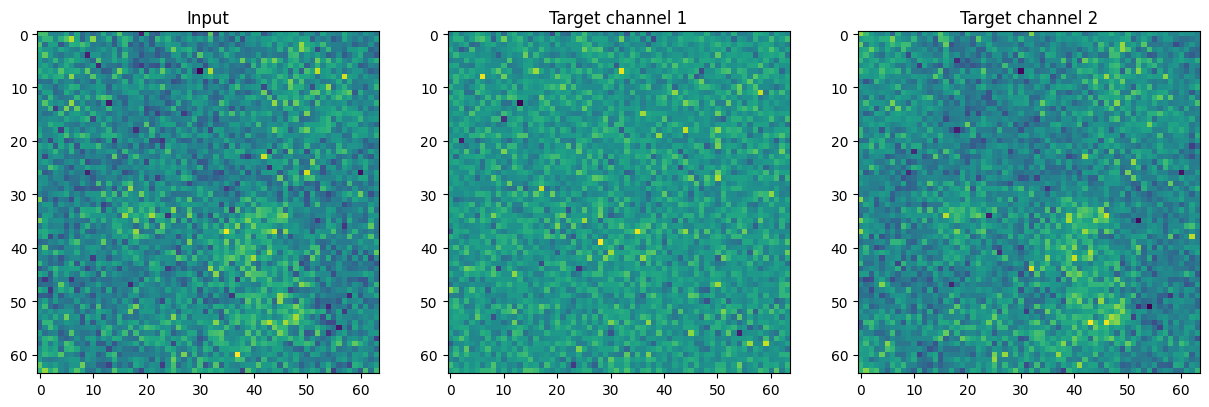

In [11]:
_, ax = plt.subplots(figsize=(15, 10), ncols=3)
inp, tar = train_dset[0]
ax[0].imshow(inp.squeeze())
ax[0].set_title("Input")
ax[1].imshow(tar[0])
ax[1].set_title("Target channel 1")
ax[2].imshow(tar[1])
ax[2].set_title("Target channel 2")

# **Step 1.3:** Train the prepared model!
***Note:*** if this takes too long, there were to places above where we gave you options to *(i)* reduce the amount of training data, and *(ii)* chose to train for fewer epochs. Revisit your choices if you want to!

***Note:*** Depending on the amount of GPU memory you have available, you might want to adjust the batch size. The default is 32, but you can reduce it to 16 if you run out of memory by changing the <i> batch_size </i> parameter in <i> get_microsplit_parameters </i> above.


In [12]:
# create a CAREamics 'Trainer'
trainer = Trainer(
    max_epochs=training_config.num_epochs,
    # NOTE: if you are on a mac swap the accelerator to "mps"
    # accelerator=“mps”,
    accelerator="gpu",
    enable_progress_bar=True,
    callbacks=get_callbacks(f"./checkpoints/"),
    precision=training_config.precision,
    gradient_clip_val=training_config.gradient_clip_val,
    gradient_clip_algorithm=training_config.gradient_clip_algorithm,
)
# start the training - yay!
trainer.fit(
    model=model,
    train_dataloaders=train_dloader,
    val_dataloaders=val_dloader,
)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A40-16Q') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
/localscratch/mamba/envs/splits/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/igor.zubarev/projects/microSplit-reproducibility/examples/2D/HT_H23B/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type                   | Params | Mode 
--------------------------------------------------------------------------
0 | model                  | LadderVAE              

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/localscratch/mamba/envs/splits/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
/localscratch/mamba/envs/splits/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/localscratch/mamba/envs/splits/lib/python3.9/site-packages/numpy/core/_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
Metric val_loss improved. New best score: 7.836


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


## Show training loss curves...
Below, we plot for each epoch of your training run the *(i)* training reconstruction loss, *(ii)* training KL divergence loss, *(iii)* validation reconstruction loss, and *(iv)* validation PSNR. 

In [ ]:
from pandas import read_csv
from microsplit_reproducibility.notebook_utils.HT_LIF24 import find_recent_metrics, plot_metrics
df = read_csv(find_recent_metrics())
plot_metrics(df)

### You are done here! 👍 Congratulations! 🎉